# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

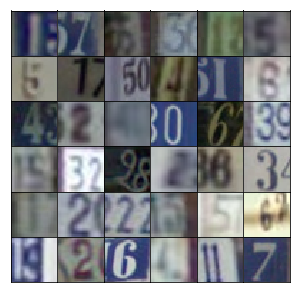

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [39]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, conv_total=3):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, units=4*4*256)
        x = tf.reshape(x, [-1, 4, 4, 256])
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x) # x.shape = (4, 4, 256)
        
        # 1st Convolution.
        conv1 = tf.layers.conv2d_transpose(x, filters=128, kernel_size=5, 
                                           strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=training)
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (8, 8, 128)
        
        # 2nd Convolution.
        conv2 = tf.layers.conv2d_transpose(conv1, filters=64, kernel_size=5, 
                                           strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(alpha*conv2, conv2) # conv1.shape = (16, 16, 64)
        
        # Convolution to output.
        logits = tf.layers.conv2d_transpose(conv2, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except **the first convolutional** (why?) and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [40]:
def discriminator(x, reuse=False, alpha=0.2):
    # Input layer is 32x32x3
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st Convolutional layer.
        conv1 = tf.layers.conv2d(x, 32, 5, 2, padding='same')
        # Skip batch normalization here.
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (16, 16, 32)
        
        # 2nd Convolutional layer.
        conv2 = tf.layers.conv2d(conv1, 64, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # conv1.shape = (8, 8, 64)
        
        # 3rd Convolutional layer.
        conv3 = tf.layers.conv2d(conv2, 128, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # conv1.shape = (4, 4, 128)
        
        # Output layer.
        conv3 = tf.reshape(conv3, (-1, 4*4*128)) # Flatten.
        logits = tf.layers.dense(conv3, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [41]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [43]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [44]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [45]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.002
batch_size = 128
epochs = 10
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/10... Discriminator Loss: 0.0315... Generator Loss: 4.5010
Epoch 1/10... Discriminator Loss: 0.0308... Generator Loss: 4.6568
Epoch 1/10... Discriminator Loss: 0.0205... Generator Loss: 4.9571
Epoch 1/10... Discriminator Loss: 0.0340... Generator Loss: 4.1787
Epoch 1/10... Discriminator Loss: 0.0079... Generator Loss: 8.5907
Epoch 1/10... Discriminator Loss: 0.0027... Generator Loss: 9.5887
Epoch 1/10... Discriminator Loss: 0.0014... Generator Loss: 7.6905
Epoch 1/10... Discriminator Loss: 0.0013... Generator Loss: 7.2871
Epoch 1/10... Discriminator Loss: 0.0046... Generator Loss: 5.6860
Epoch 1/10... Discriminator Loss: 0.0072... Generator Loss: 5.7600


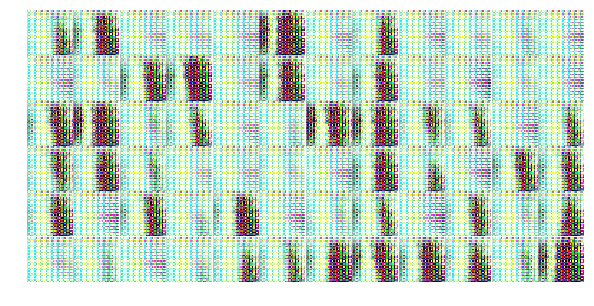

Epoch 1/10... Discriminator Loss: 0.0128... Generator Loss: 5.2466
Epoch 1/10... Discriminator Loss: 0.0058... Generator Loss: 5.8083
Epoch 1/10... Discriminator Loss: 0.0043... Generator Loss: 7.6396
Epoch 1/10... Discriminator Loss: 0.0312... Generator Loss: 4.8258
Epoch 1/10... Discriminator Loss: 2.7066... Generator Loss: 3.3296
Epoch 1/10... Discriminator Loss: 0.0719... Generator Loss: 6.6452
Epoch 1/10... Discriminator Loss: 0.0706... Generator Loss: 4.8630
Epoch 1/10... Discriminator Loss: 0.1018... Generator Loss: 3.3019
Epoch 1/10... Discriminator Loss: 0.1171... Generator Loss: 2.9847
Epoch 1/10... Discriminator Loss: 0.0110... Generator Loss: 6.7744


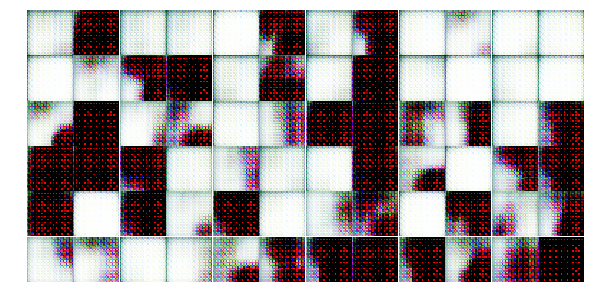

Epoch 1/10... Discriminator Loss: 0.0186... Generator Loss: 10.9928
Epoch 1/10... Discriminator Loss: 0.0601... Generator Loss: 3.3053
Epoch 1/10... Discriminator Loss: 0.0526... Generator Loss: 9.2195
Epoch 1/10... Discriminator Loss: 0.1319... Generator Loss: 6.2333
Epoch 1/10... Discriminator Loss: 0.0412... Generator Loss: 5.7964
Epoch 1/10... Discriminator Loss: 0.1787... Generator Loss: 2.8990
Epoch 1/10... Discriminator Loss: 0.0158... Generator Loss: 5.4472
Epoch 1/10... Discriminator Loss: 0.0332... Generator Loss: 5.9147
Epoch 1/10... Discriminator Loss: 0.2673... Generator Loss: 1.7705
Epoch 1/10... Discriminator Loss: 0.1100... Generator Loss: 4.2043


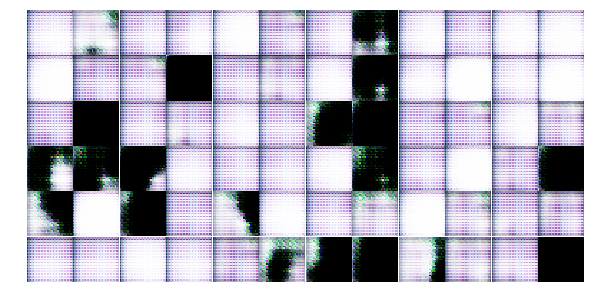

Epoch 1/10... Discriminator Loss: 0.1303... Generator Loss: 4.9497
Epoch 1/10... Discriminator Loss: 0.0245... Generator Loss: 5.4512
Epoch 1/10... Discriminator Loss: 0.0955... Generator Loss: 4.6600
Epoch 1/10... Discriminator Loss: 0.0485... Generator Loss: 5.0280
Epoch 1/10... Discriminator Loss: 0.0159... Generator Loss: 7.4590
Epoch 1/10... Discriminator Loss: 0.0555... Generator Loss: 5.2055
Epoch 1/10... Discriminator Loss: 0.1548... Generator Loss: 2.8754
Epoch 1/10... Discriminator Loss: 0.0174... Generator Loss: 4.9254
Epoch 1/10... Discriminator Loss: 0.0361... Generator Loss: 6.3818
Epoch 1/10... Discriminator Loss: 0.0544... Generator Loss: 4.7546


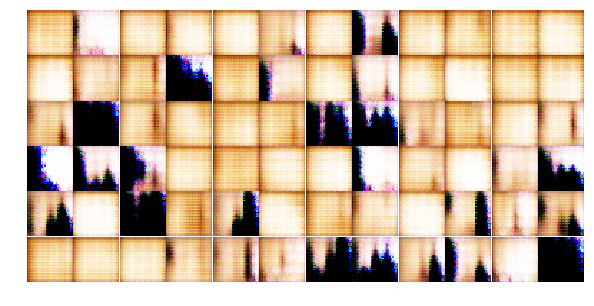

Epoch 1/10... Discriminator Loss: 0.0331... Generator Loss: 4.6240
Epoch 1/10... Discriminator Loss: 0.1707... Generator Loss: 8.7184
Epoch 1/10... Discriminator Loss: 1.3785... Generator Loss: 0.6729
Epoch 1/10... Discriminator Loss: 0.1304... Generator Loss: 4.0563
Epoch 1/10... Discriminator Loss: 0.1129... Generator Loss: 5.6034
Epoch 1/10... Discriminator Loss: 0.3389... Generator Loss: 2.9410
Epoch 1/10... Discriminator Loss: 0.3017... Generator Loss: 2.9030
Epoch 1/10... Discriminator Loss: 0.2209... Generator Loss: 3.6945
Epoch 1/10... Discriminator Loss: 0.1104... Generator Loss: 4.6832
Epoch 1/10... Discriminator Loss: 0.0246... Generator Loss: 4.5604


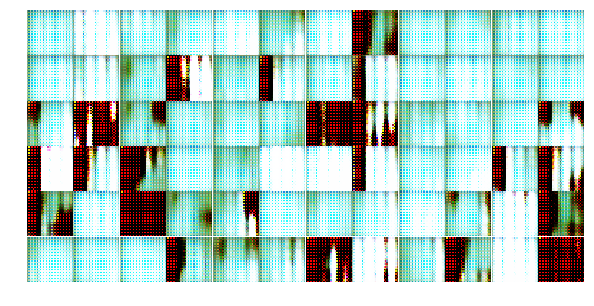

Epoch 1/10... Discriminator Loss: 0.0187... Generator Loss: 5.7355
Epoch 1/10... Discriminator Loss: 0.0587... Generator Loss: 4.5802
Epoch 1/10... Discriminator Loss: 0.0469... Generator Loss: 4.4336
Epoch 1/10... Discriminator Loss: 0.1027... Generator Loss: 3.7220
Epoch 1/10... Discriminator Loss: 0.1358... Generator Loss: 11.0996
Epoch 1/10... Discriminator Loss: 0.0155... Generator Loss: 8.3741
Epoch 1/10... Discriminator Loss: 0.0252... Generator Loss: 5.9979
Epoch 2/10... Discriminator Loss: 0.1712... Generator Loss: 6.6013
Epoch 2/10... Discriminator Loss: 0.8636... Generator Loss: 1.3453
Epoch 2/10... Discriminator Loss: 0.0491... Generator Loss: 5.0625


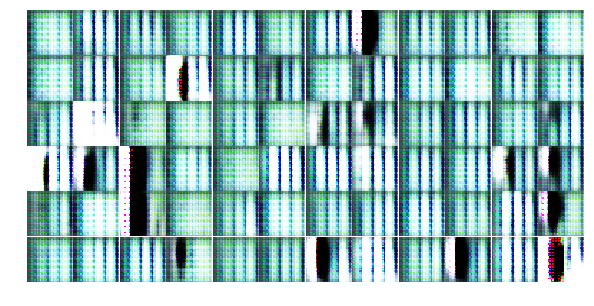

Epoch 2/10... Discriminator Loss: 0.0962... Generator Loss: 3.5145
Epoch 2/10... Discriminator Loss: 0.1003... Generator Loss: 3.0616
Epoch 2/10... Discriminator Loss: 0.0307... Generator Loss: 4.3208
Epoch 2/10... Discriminator Loss: 0.0859... Generator Loss: 8.1560
Epoch 2/10... Discriminator Loss: 0.2673... Generator Loss: 6.4963
Epoch 2/10... Discriminator Loss: 0.1441... Generator Loss: 6.7918
Epoch 2/10... Discriminator Loss: 0.0212... Generator Loss: 5.7239
Epoch 2/10... Discriminator Loss: 0.0490... Generator Loss: 5.6704
Epoch 2/10... Discriminator Loss: 0.0369... Generator Loss: 6.0540
Epoch 2/10... Discriminator Loss: 0.1180... Generator Loss: 2.8865


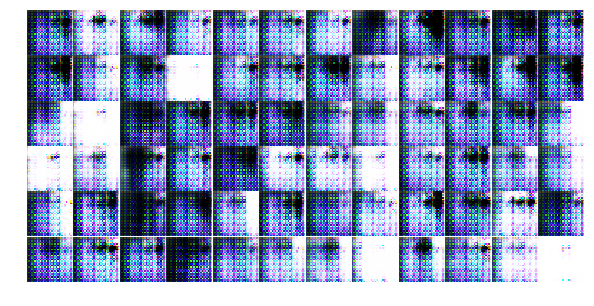

Epoch 2/10... Discriminator Loss: 0.0798... Generator Loss: 5.2101
Epoch 2/10... Discriminator Loss: 0.1022... Generator Loss: 12.6463
Epoch 2/10... Discriminator Loss: 0.0202... Generator Loss: 5.6167
Epoch 2/10... Discriminator Loss: 0.0124... Generator Loss: 6.0168
Epoch 2/10... Discriminator Loss: 0.1193... Generator Loss: 3.5789
Epoch 2/10... Discriminator Loss: 0.0090... Generator Loss: 7.1549
Epoch 2/10... Discriminator Loss: 0.0326... Generator Loss: 6.5453
Epoch 2/10... Discriminator Loss: 0.0507... Generator Loss: 5.6157
Epoch 2/10... Discriminator Loss: 0.0857... Generator Loss: 4.7518
Epoch 2/10... Discriminator Loss: 0.1211... Generator Loss: 11.5278


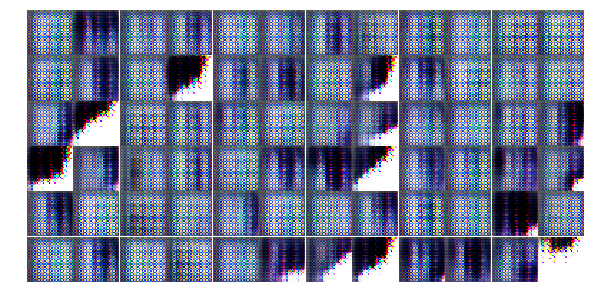

Epoch 2/10... Discriminator Loss: 0.1689... Generator Loss: 3.5861
Epoch 2/10... Discriminator Loss: 0.3008... Generator Loss: 3.2183
Epoch 2/10... Discriminator Loss: 0.2251... Generator Loss: 5.5182
Epoch 2/10... Discriminator Loss: 0.5593... Generator Loss: 1.5272
Epoch 2/10... Discriminator Loss: 0.2725... Generator Loss: 2.4751
Epoch 2/10... Discriminator Loss: 0.1176... Generator Loss: 3.4142
Epoch 2/10... Discriminator Loss: 0.0830... Generator Loss: 5.0310
Epoch 2/10... Discriminator Loss: 0.1025... Generator Loss: 3.8718
Epoch 2/10... Discriminator Loss: 0.0744... Generator Loss: 5.3167
Epoch 2/10... Discriminator Loss: 0.2224... Generator Loss: 4.4709


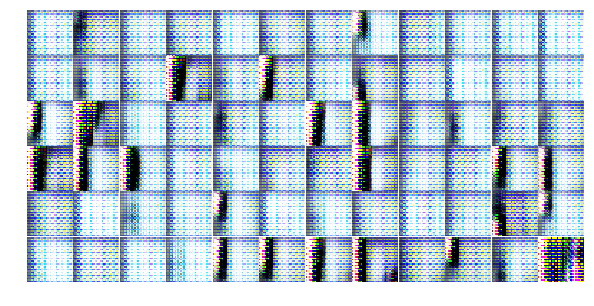

Epoch 2/10... Discriminator Loss: 0.0583... Generator Loss: 6.1788
Epoch 2/10... Discriminator Loss: 0.1993... Generator Loss: 4.6462
Epoch 2/10... Discriminator Loss: 1.7375... Generator Loss: 12.4460
Epoch 2/10... Discriminator Loss: 0.0914... Generator Loss: 6.4985
Epoch 2/10... Discriminator Loss: 0.4439... Generator Loss: 2.2438
Epoch 2/10... Discriminator Loss: 0.3599... Generator Loss: 6.6950
Epoch 2/10... Discriminator Loss: 0.2171... Generator Loss: 2.8803
Epoch 2/10... Discriminator Loss: 0.9260... Generator Loss: 1.0761
Epoch 2/10... Discriminator Loss: 0.3472... Generator Loss: 4.2035
Epoch 2/10... Discriminator Loss: 0.1742... Generator Loss: 2.8459


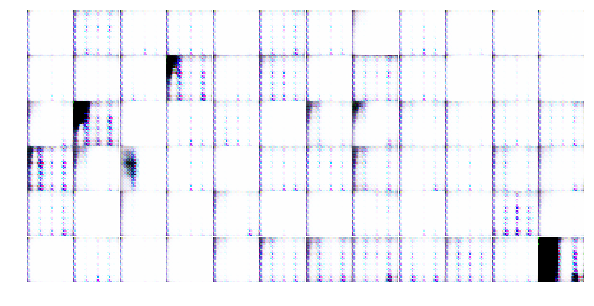

Epoch 2/10... Discriminator Loss: 0.1377... Generator Loss: 2.6500
Epoch 2/10... Discriminator Loss: 0.4144... Generator Loss: 1.7349
Epoch 2/10... Discriminator Loss: 0.7137... Generator Loss: 1.7725
Epoch 2/10... Discriminator Loss: 0.0204... Generator Loss: 5.2672
Epoch 2/10... Discriminator Loss: 0.0584... Generator Loss: 6.3003
Epoch 2/10... Discriminator Loss: 0.1352... Generator Loss: 4.4217
Epoch 2/10... Discriminator Loss: 0.4331... Generator Loss: 2.4658
Epoch 2/10... Discriminator Loss: 0.1589... Generator Loss: 5.5428
Epoch 2/10... Discriminator Loss: 0.0486... Generator Loss: 4.1954
Epoch 2/10... Discriminator Loss: 0.1108... Generator Loss: 4.6724


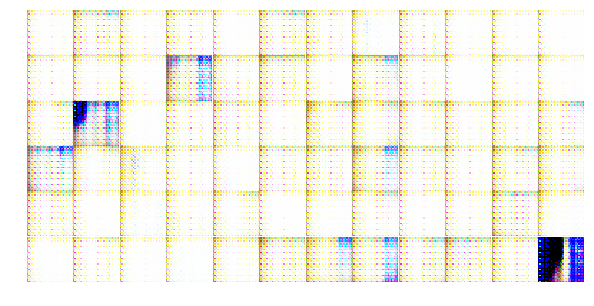

Epoch 2/10... Discriminator Loss: 0.1492... Generator Loss: 4.1251
Epoch 2/10... Discriminator Loss: 0.1184... Generator Loss: 4.0148
Epoch 2/10... Discriminator Loss: 0.0775... Generator Loss: 4.2268
Epoch 2/10... Discriminator Loss: 0.0992... Generator Loss: 4.5852
Epoch 3/10... Discriminator Loss: 0.0200... Generator Loss: 6.1293
Epoch 3/10... Discriminator Loss: 0.0835... Generator Loss: 4.2135
Epoch 3/10... Discriminator Loss: 0.8486... Generator Loss: 1.2966
Epoch 3/10... Discriminator Loss: 0.1288... Generator Loss: 4.9966
Epoch 3/10... Discriminator Loss: 0.1648... Generator Loss: 3.6704
Epoch 3/10... Discriminator Loss: 0.1526... Generator Loss: 5.9412


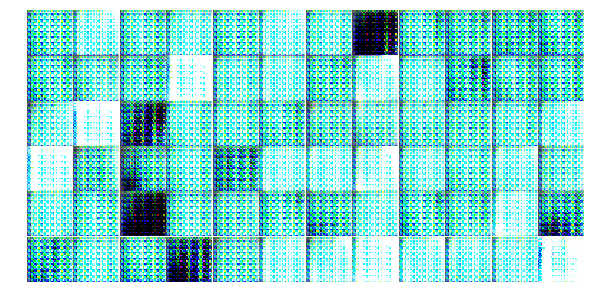

Epoch 3/10... Discriminator Loss: 0.0266... Generator Loss: 5.3182
Epoch 3/10... Discriminator Loss: 0.0097... Generator Loss: 5.9699
Epoch 3/10... Discriminator Loss: 0.0371... Generator Loss: 4.7358
Epoch 3/10... Discriminator Loss: 0.7391... Generator Loss: 1.1709
Epoch 3/10... Discriminator Loss: 0.0605... Generator Loss: 5.6962
Epoch 3/10... Discriminator Loss: 0.1093... Generator Loss: 4.2792
Epoch 3/10... Discriminator Loss: 0.7387... Generator Loss: 5.0283
Epoch 3/10... Discriminator Loss: 0.8936... Generator Loss: 1.3817
Epoch 3/10... Discriminator Loss: 0.1563... Generator Loss: 3.0102
Epoch 3/10... Discriminator Loss: 0.0804... Generator Loss: 3.4866


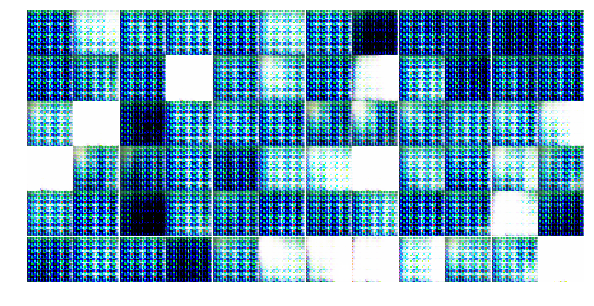

Epoch 3/10... Discriminator Loss: 0.0880... Generator Loss: 3.1447
Epoch 3/10... Discriminator Loss: 0.1389... Generator Loss: 2.6260
Epoch 3/10... Discriminator Loss: 0.5623... Generator Loss: 3.9686
Epoch 3/10... Discriminator Loss: 0.4930... Generator Loss: 1.3591
Epoch 3/10... Discriminator Loss: 0.0909... Generator Loss: 3.5549
Epoch 3/10... Discriminator Loss: 0.1247... Generator Loss: 2.9116
Epoch 3/10... Discriminator Loss: 0.0898... Generator Loss: 3.2285
Epoch 3/10... Discriminator Loss: 0.0544... Generator Loss: 5.6388
Epoch 3/10... Discriminator Loss: 0.9024... Generator Loss: 1.2208
Epoch 3/10... Discriminator Loss: 0.5066... Generator Loss: 2.4297


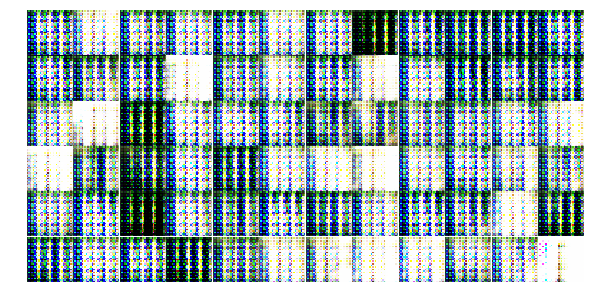

Epoch 3/10... Discriminator Loss: 0.0815... Generator Loss: 4.1868
Epoch 3/10... Discriminator Loss: 0.2898... Generator Loss: 4.4244
Epoch 3/10... Discriminator Loss: 0.4820... Generator Loss: 3.9024
Epoch 3/10... Discriminator Loss: 1.0655... Generator Loss: 2.1509
Epoch 3/10... Discriminator Loss: 0.4266... Generator Loss: 1.6923
Epoch 3/10... Discriminator Loss: 0.5679... Generator Loss: 2.2676
Epoch 3/10... Discriminator Loss: 0.2470... Generator Loss: 2.4505
Epoch 3/10... Discriminator Loss: 0.3412... Generator Loss: 2.7809
Epoch 3/10... Discriminator Loss: 0.2643... Generator Loss: 2.7384
Epoch 3/10... Discriminator Loss: 0.4998... Generator Loss: 3.6999


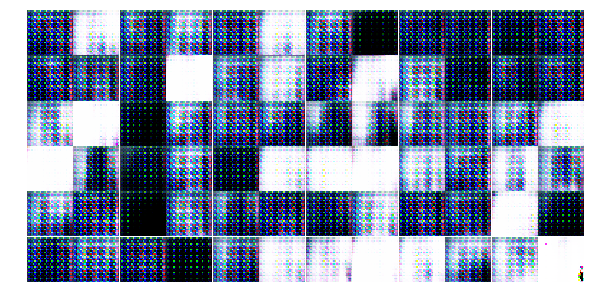

Epoch 3/10... Discriminator Loss: 0.4755... Generator Loss: 1.9205
Epoch 3/10... Discriminator Loss: 0.1431... Generator Loss: 3.1705
Epoch 3/10... Discriminator Loss: 0.1828... Generator Loss: 4.1203
Epoch 3/10... Discriminator Loss: 0.0109... Generator Loss: 7.9418
Epoch 3/10... Discriminator Loss: 0.2410... Generator Loss: 6.0278
Epoch 3/10... Discriminator Loss: 0.0327... Generator Loss: 6.3555
Epoch 3/10... Discriminator Loss: 0.0063... Generator Loss: 5.9364
Epoch 3/10... Discriminator Loss: 0.0740... Generator Loss: 3.5628
Epoch 3/10... Discriminator Loss: 0.2268... Generator Loss: 3.1794
Epoch 3/10... Discriminator Loss: 0.0814... Generator Loss: 3.9864


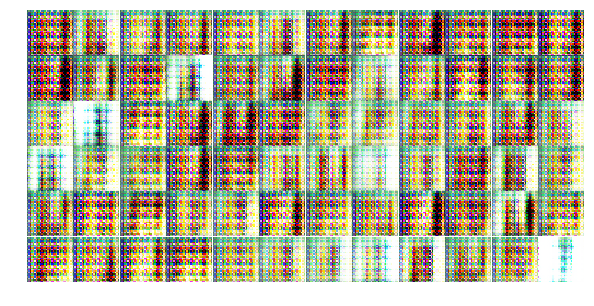

Epoch 3/10... Discriminator Loss: 0.1810... Generator Loss: 3.2510
Epoch 3/10... Discriminator Loss: 0.6431... Generator Loss: 1.2992
Epoch 3/10... Discriminator Loss: 0.2748... Generator Loss: 3.0381
Epoch 3/10... Discriminator Loss: 0.1565... Generator Loss: 2.6401
Epoch 3/10... Discriminator Loss: 0.2704... Generator Loss: 2.9647
Epoch 3/10... Discriminator Loss: 0.0432... Generator Loss: 4.8971
Epoch 3/10... Discriminator Loss: 0.1180... Generator Loss: 3.4062
Epoch 3/10... Discriminator Loss: 0.0885... Generator Loss: 8.4958
Epoch 3/10... Discriminator Loss: 1.9210... Generator Loss: 0.3700
Epoch 3/10... Discriminator Loss: 0.3235... Generator Loss: 4.0092


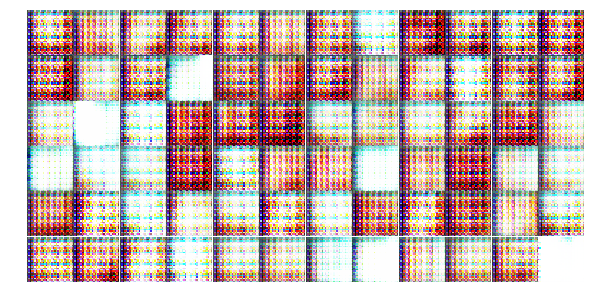

Epoch 3/10... Discriminator Loss: 2.5872... Generator Loss: 6.0745
Epoch 4/10... Discriminator Loss: 0.3348... Generator Loss: 3.1497
Epoch 4/10... Discriminator Loss: 0.2232... Generator Loss: 2.7472
Epoch 4/10... Discriminator Loss: 0.0780... Generator Loss: 5.0781
Epoch 4/10... Discriminator Loss: 0.0858... Generator Loss: 5.6932
Epoch 4/10... Discriminator Loss: 0.0683... Generator Loss: 4.4996
Epoch 4/10... Discriminator Loss: 0.1919... Generator Loss: 3.3383
Epoch 4/10... Discriminator Loss: 0.2218... Generator Loss: 2.3173
Epoch 4/10... Discriminator Loss: 0.1672... Generator Loss: 4.2064
Epoch 4/10... Discriminator Loss: 0.3304... Generator Loss: 2.6132


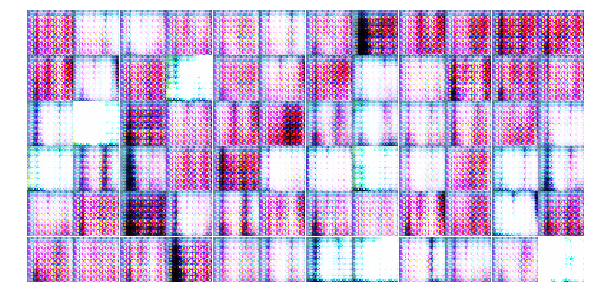

Epoch 4/10... Discriminator Loss: 0.2027... Generator Loss: 4.1204
Epoch 4/10... Discriminator Loss: 0.0713... Generator Loss: 4.8975
Epoch 4/10... Discriminator Loss: 0.3412... Generator Loss: 4.1260
Epoch 4/10... Discriminator Loss: 0.0274... Generator Loss: 4.5468
Epoch 4/10... Discriminator Loss: 0.1342... Generator Loss: 3.2390
Epoch 4/10... Discriminator Loss: 0.4647... Generator Loss: 2.7865
Epoch 4/10... Discriminator Loss: 0.2504... Generator Loss: 3.7535
Epoch 4/10... Discriminator Loss: 0.5357... Generator Loss: 1.4678
Epoch 4/10... Discriminator Loss: 0.1735... Generator Loss: 4.5421
Epoch 4/10... Discriminator Loss: 0.5369... Generator Loss: 1.9498


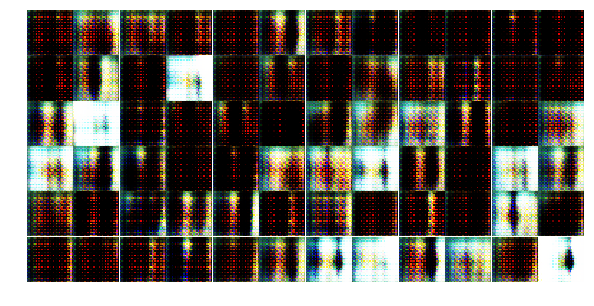

Epoch 4/10... Discriminator Loss: 0.1957... Generator Loss: 4.3417
Epoch 4/10... Discriminator Loss: 0.1084... Generator Loss: 4.7996
Epoch 4/10... Discriminator Loss: 0.5872... Generator Loss: 1.2512
Epoch 4/10... Discriminator Loss: 0.2886... Generator Loss: 2.3823
Epoch 4/10... Discriminator Loss: 0.0468... Generator Loss: 3.7541
Epoch 4/10... Discriminator Loss: 0.0857... Generator Loss: 3.3293
Epoch 4/10... Discriminator Loss: 0.8040... Generator Loss: 0.9501
Epoch 4/10... Discriminator Loss: 0.0886... Generator Loss: 5.3288
Epoch 4/10... Discriminator Loss: 0.1962... Generator Loss: 2.3565
Epoch 4/10... Discriminator Loss: 0.0692... Generator Loss: 6.4409


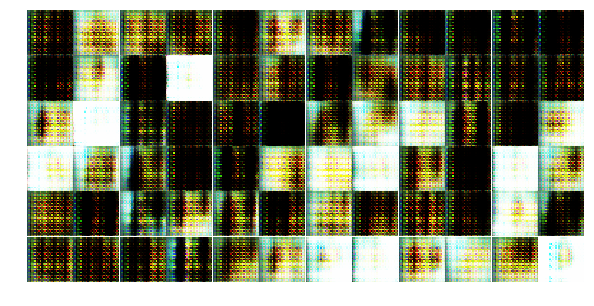

Epoch 4/10... Discriminator Loss: 0.3758... Generator Loss: 2.4448
Epoch 4/10... Discriminator Loss: 0.1200... Generator Loss: 5.5433
Epoch 4/10... Discriminator Loss: 0.1951... Generator Loss: 3.6770
Epoch 4/10... Discriminator Loss: 0.1532... Generator Loss: 4.4841
Epoch 4/10... Discriminator Loss: 0.6491... Generator Loss: 1.4700
Epoch 4/10... Discriminator Loss: 0.8109... Generator Loss: 1.2894
Epoch 4/10... Discriminator Loss: 0.6766... Generator Loss: 5.7766
Epoch 4/10... Discriminator Loss: 0.4134... Generator Loss: 4.0865
Epoch 4/10... Discriminator Loss: 0.0568... Generator Loss: 4.2642
Epoch 4/10... Discriminator Loss: 0.1879... Generator Loss: 2.9113


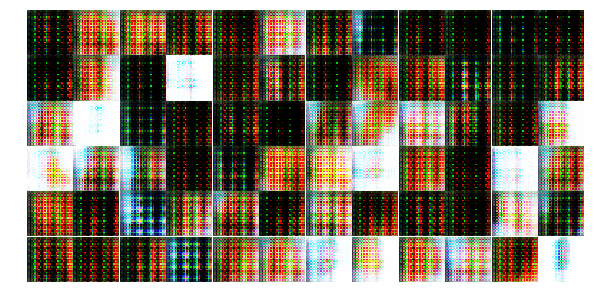

Epoch 4/10... Discriminator Loss: 0.6338... Generator Loss: 1.1569
Epoch 4/10... Discriminator Loss: 0.1679... Generator Loss: 4.0092
Epoch 4/10... Discriminator Loss: 0.2752... Generator Loss: 2.4512
Epoch 4/10... Discriminator Loss: 0.2609... Generator Loss: 2.5810
Epoch 4/10... Discriminator Loss: 0.2411... Generator Loss: 2.5647
Epoch 4/10... Discriminator Loss: 0.3165... Generator Loss: 3.0211
Epoch 4/10... Discriminator Loss: 0.5836... Generator Loss: 1.5082
Epoch 4/10... Discriminator Loss: 2.5081... Generator Loss: 5.1038
Epoch 4/10... Discriminator Loss: 0.0625... Generator Loss: 5.1931
Epoch 4/10... Discriminator Loss: 0.8013... Generator Loss: 1.1764


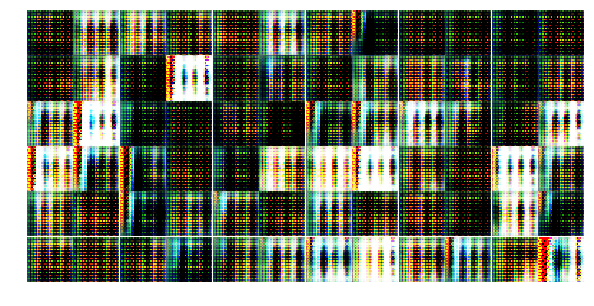

Epoch 4/10... Discriminator Loss: 0.2228... Generator Loss: 3.0684
Epoch 4/10... Discriminator Loss: 0.1556... Generator Loss: 3.9043
Epoch 4/10... Discriminator Loss: 0.1741... Generator Loss: 2.9657
Epoch 4/10... Discriminator Loss: 0.0385... Generator Loss: 5.3282
Epoch 4/10... Discriminator Loss: 0.4708... Generator Loss: 5.5920
Epoch 4/10... Discriminator Loss: 0.1611... Generator Loss: 2.6921
Epoch 4/10... Discriminator Loss: 0.2369... Generator Loss: 3.1050
Epoch 4/10... Discriminator Loss: 0.0735... Generator Loss: 4.3876
Epoch 4/10... Discriminator Loss: 0.1326... Generator Loss: 3.7605
Epoch 5/10... Discriminator Loss: 0.1244... Generator Loss: 4.5174


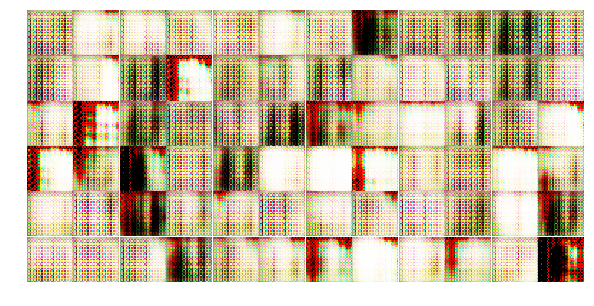

Epoch 5/10... Discriminator Loss: 0.1072... Generator Loss: 3.3393


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))